**Goal**: investigate instruments to summarize very long documents (> 200 pages).

**Read** the full article at Medium: [Summarizing Long Documents: from Gemini to Clustering](https://medium.com/@kate.ruksha/summarizing-long-documents-from-gemini-to-clustering-59d591dee873)

**Plan**:
1. Baseline,
2. Stuffing,
3. MapReduce,
4. Refine,
5. K-means,
6. RAPTOR.

# Setup

In [ ]:
!pip install pypdf
!pip install openai==0.28
!pip install pandas
!pip install langchain
!pip install langchain_openai
!pip install langchain_community
!pip install llama-index==0.9.42
!pip install -U -q google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.8/384.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.3/361.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install rouge
!pip install bert_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import json, os, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import openai
from pathlib import Path as p
from pypdf import PdfReader

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from itertools import chain
from typing import Callable, List, Dict, Union

# Langchain blocks
from langchain.llms import VertexAI
from langchain import PromptTemplate
from langchain.chains import LLMChain

from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain_community.chat_models import ChatOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.llms import OpenAI, OpenAIChat, HuggingFaceHub

In [ ]:
import torch
from rouge import Rouge
from bert_score import score

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
with open("openai_credentials.json", 'rb') as f:
    os.environ["OPENAI_API_KEY"] = json.load(f)['OPENAI_API_KEY']
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
import google.generativeai as genai
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
def get_metrics(reference_summary,
                generated_summary):

    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summary, reference_summary)
    print('Rouge score: ', rouge_scores)

    P, R, F1 = score([generated_summary], [reference_summary], lang="en")
    print(f'BERTscore: {P, R, F1}')

    return {'ROUGE': rouge_scores,
            'BERTscore': [P, R, F1]}

# Prepare texts

In [ ]:
# Create the text for summarization
pdf_loader = PyPDFLoader('AIA-COM-Impact-Assessment-3-21-April.pdf')
pages = pdf_loader.load_and_split()

test_pages = []
text = ''
for i in range(len(pages)):
    if (i < 7) or (i > 21):
        test_pages.append(pages[i] )
        text += pages[i].dict()['page_content']

print(len(test_pages))
print(len(text))

238
575698


In [ ]:
# Extract summary from the paper:
reader = PdfReader('AIA-COM-Impact-Assessment-3-21-April.pdf')
executive_summary = ''
for i in range(len(reader.pages)):
    if (i > 7) and (i < 14):
        # creating a page object
        page = reader.pages[i]

        # extracting text from page
        a = page.extract_text()
        executive_summary += a

print(len(executive_summary))

In [ ]:
with open('input.txt', 'w', encoding='utf-8') as f:
    f.write(text)

In [ ]:
len(text) /4 # approximate number of tokens

143924.5

# Baseline

In [ ]:
# Summarize the baseline summary
llm = ChatOpenAI(model_name="gpt-4") #"gpt-3.5-turbo-instruct"

template = """Input: {executive_summary}
Summarize given text to about 3k characters."""

prompt = PromptTemplate.from_template(template)
llm_chain = prompt | llm

baseline_summary = llm_chain.invoke(executive_summary)
print(len(baseline_summary.content))
print(baseline_summary.content)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


2048
This study, commissioned by the European Commission, DG CONNECT, supports the impact assessment of the European Commission's proposal for a Regulation on a European approach to artificial intelligence (AI). The report is divided into four main sections.

Section 1 provides an overview of existing evidence and forward-looking assessments of the risks and harms generated by AI for fundamental rights and safety/security.

Section 2 provides a comparative overview of emerging national experiences in developing strategies and regulatory frameworks in this area, with a particular focus on risk governance.

Section 3 contains a detailed analysis of the results of the public consultation on the European Commission's White Paper on Artificial Intelligence. It includes the analysis of 18 free text questions from the consultation on the white paper (6,667 free text responses) and the review of 408 position papers submitted to the public consultation.

Section 4 is dedicated to an assessment 

# Stuffing
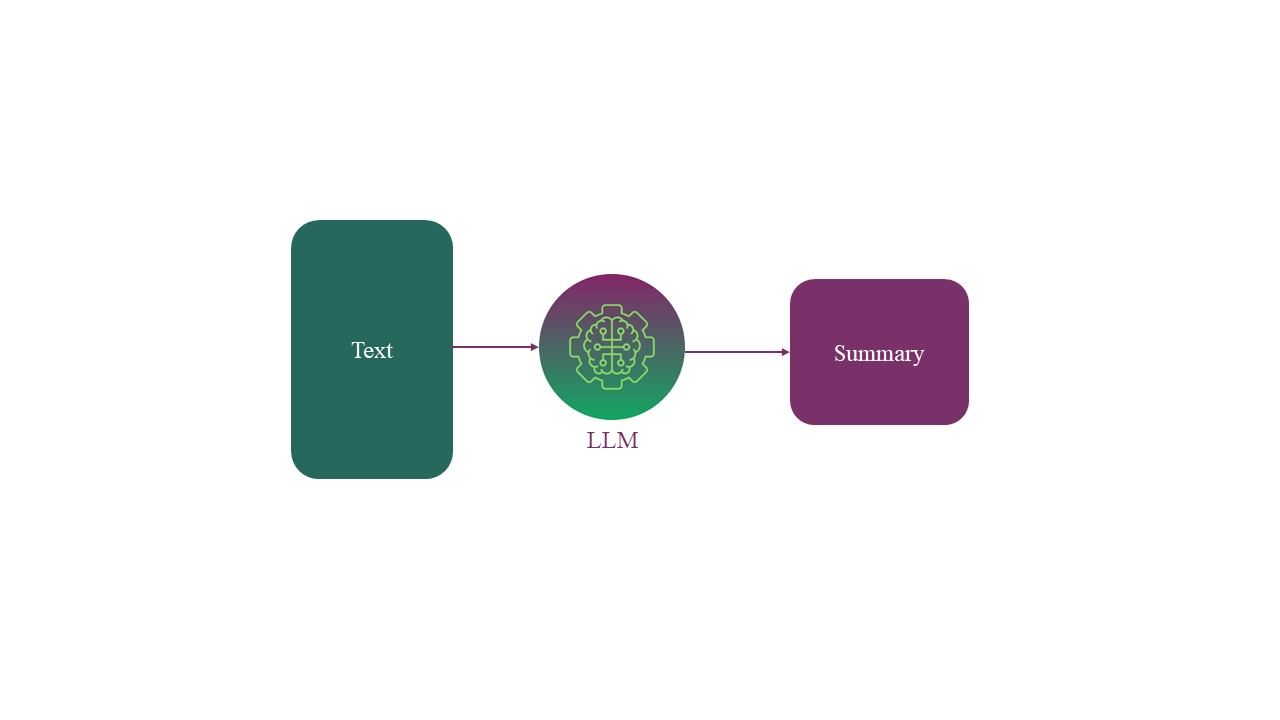

The stuffing method is a way to summarize text by feeding the entire document to a large language model (LLM) in a single call.

The stuffing method only requires a single call to the LLM, which can be faster than other methods that require multiple calls. When summarizing text, the LLM has access to all the data at once, which can result in a better summary.

## GPT-4

In [ ]:
prompt_template = """Write summary of the document by sections, then add key findings and conclusion.
The total length of the summary should be up to 3000 characters.
Input: ```{text}```
  """

prompt = PromptTemplate(template=prompt_template, input_variables=["text"])
stuff_chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt)

In [ ]:
try:
    print(stuff_chain.run(test_pages))
except Exception as e:
    print(
        "The code failed since it won't be able to run inference on such a huge context and throws this exception: ",
        e,
    )

The code failed since it won't be able to run inference on such a huge context and throws this exception:  Error code: 429 - {'error': {'message': 'Request too large for gpt-4 in organization org-TypQjl2wOsYpdP8uN8llEbYl on tokens per min (TPM): Limit 10000, Requested 145365. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


## Gemini Pro

In [ ]:
text_file_name = "input.txt"
print(f"Uploading file...")
text_file = genai.upload_file(path=text_file_name)
print(f"Completed upload: {text_file.uri}")

Uploading file...
Completed upload: https://generativelanguage.googleapis.com/v1beta/files/f0b4do1asg2l


In [2]:
prompt = """Write summary of the document by sections, then add key findings and conclusion.
The total length of the summary should be up to 3000 characters."""

model = genai.GenerativeModel(model_name="models/gemini-1.5-pro")

response = model.generate_content([prompt, text_file],
                                  request_options={"timeout": 600}).text
print(response)

This study examines the potential impact of the proposed European AI Regulation.
Section 1: Explores risks AI poses to fundamental rights, including bias, erosion of human agency, and compromised data protection. It highlights examples of AI systems causing discrimination and privacy violations, emphasizing the need for context-dependent risk assessments and oversight.
Section 2: Analyzes international AI policy approaches, focusing on emerging regulatory frameworks. It covers voluntary guidelines (Australia), sector-specific directives (Canada), risk classifications (Germany), and contractual guidelines (Japan).
Section 3: Summarizes the public consultation on the EU White Paper on AI. Key concerns included unclear definitions of "high-risk AI," potential regulatory burdens, and the need for robust human oversight.
Section 4: Estimates compliance costs associated with the AI Regulation. It projects a cost of €131-€345 million for the EU economy in 2022, rising to €1.5 billion by 2025.

In [ ]:
len(response)

1443

In [ ]:
gemini_scores = get_metrics(baseline_summary.content,
                generated_summary = response)

Rouge score:  [{'rouge-1': {'r': 0.2655367231638418, 'p': 0.35074626865671643, 'f': 0.30225079895410517}, 'rouge-2': {'r': 0.07342657342657342, 'p': 0.11170212765957446, 'f': 0.08860759015043912}, 'rouge-l': {'r': 0.2598870056497175, 'p': 0.34328358208955223, 'f': 0.2958199307869026}}]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTscore: (tensor([0.8724]), tensor([0.8638]), tensor([0.8681]))


The pros and cons of stuffing are:
* (+) a single call to the LLM,
* (-) a limited context window,
* (-) probability of "lost in the middle" issue.

# MapReduce
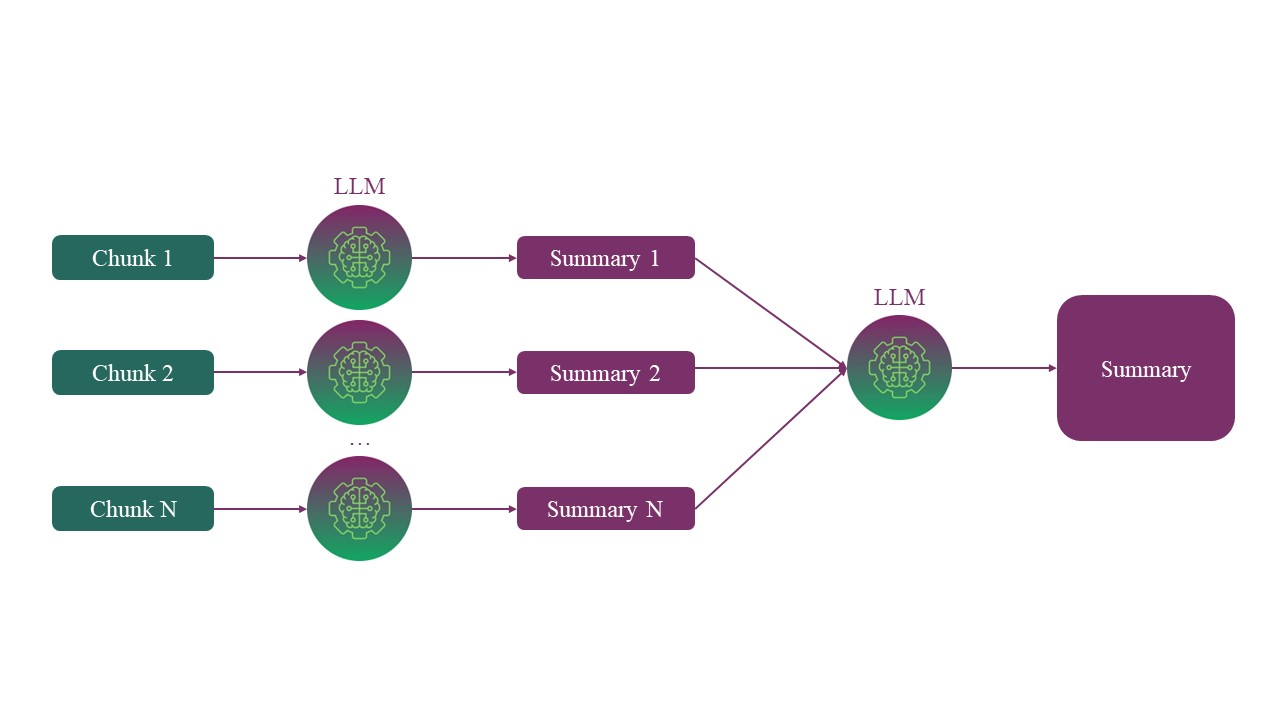
The MapReduce method implements a multi-stage summarization. It is a technique for summarizing large pieces of text by first summarizing smaller chunks of text and then combining those summaries into a single summary.

In [ ]:
map_prompt_template = """
                      Write a summary of this chunk of text that includes the main points and any important details.
                      {text}
                      """

map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

combine_prompt_template = """Write summary of the document by sections, then add key findings and conclusion.
The total length of the summary should be up to 3000 characters.
Input: ```{text}```
  """

combine_prompt = PromptTemplate(
    template=combine_prompt_template, input_variables=["text"]
)

In [ ]:
# initialize mapreduce:
map_reduce_chain = load_summarize_chain(
    llm,
    chain_type="map_reduce",
    map_prompt=map_prompt,
    combine_prompt=combine_prompt,
    return_intermediate_steps=True,
    token_max=100000
)

In [ ]:
%%time
# generate summaries:
map_reduce_outputs = map_reduce_chain({"input_documents": test_pages}) # time:12 mins

In [ ]:
from pathlib import Path as p
final_mp_data = []
for doc, out in zip(
    map_reduce_outputs["input_documents"], map_reduce_outputs["intermediate_steps"]
):
    output = {}
    output["file_name"] = p(doc.metadata["source"]).stem
    output["file_type"] = p(doc.metadata["source"]).suffix
    output["page_number"] = doc.metadata["page"]
    output["chunks"] = doc.page_content
    output["concise_summary"] = out
    final_mp_data.append(output)

In [4]:
pdf_mp_summary = pd.DataFrame.from_dict(final_mp_data)
pdf_mp_summary = pdf_mp_summary.sort_values(
    by=["file_name", "page_number"]
)  # sorting the dataframe by filename and page_number
pdf_mp_summary.reset_index(inplace=True, drop=True)
print(map_reduce_outputs['output_text'])

Here is a 3000 character summary of the key points and findings from the provided text:

Main Points:
1. Purpose: The study aims to support an impact assessment of regulatory requirements for artificial intelligence (AI) in Europe.

2. Authorship: The report was written by a team of researchers from CEPS, ICF, and Wavestone, led by Andrea Renda.

3. Title: "Study to Support an Impact Assessment of Regulatory Requirements for Artificial Intelligence in Europe"

4. Document Type: Final Report (D5)

Key Findings:
1. The rise of AI and its risks for fundamental rights and safety:
   - Overview of how AI affects fundamental rights, including in government decision-making and other areas
   - Systematic review of safety and security risks posed by AI

2. International experience of AI policy and emerging regulatory frameworks:
   - Overview of AI policy approaches in various countries, including Australia, Canada, Germany, Japan, Singapore, UK, and US
   - Other proposed policy initiatives o

In [ ]:
mapreduce_scores = get_metrics(baseline_summary.content,
                generated_summary = map_reduce_outputs['output_text'])

Rouge score:  [{'rouge-1': {'r': 0.3672316384180791, 'p': 0.35911602209944754, 'f': 0.363128486620736}, 'rouge-2': {'r': 0.14335664335664336, 'p': 0.13666666666666666, 'f': 0.1399317356171885}, 'rouge-l': {'r': 0.327683615819209, 'p': 0.32044198895027626, 'f': 0.3240223413693394}}]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTscore: (tensor([0.8415]), tensor([0.8607]), tensor([0.8510]))


With MapReduce method, the model is able to summarize a large paper by overcoming the context limit of Stuffing method with parallel processing.

MapReduce has its pros and cons:
* (+) overcomes context window limitation,
* (-) multiple calls to LLM,
* (+) possibility of parallelization of calls to save time,
* (-) possible loss of context between pages.

# Refine

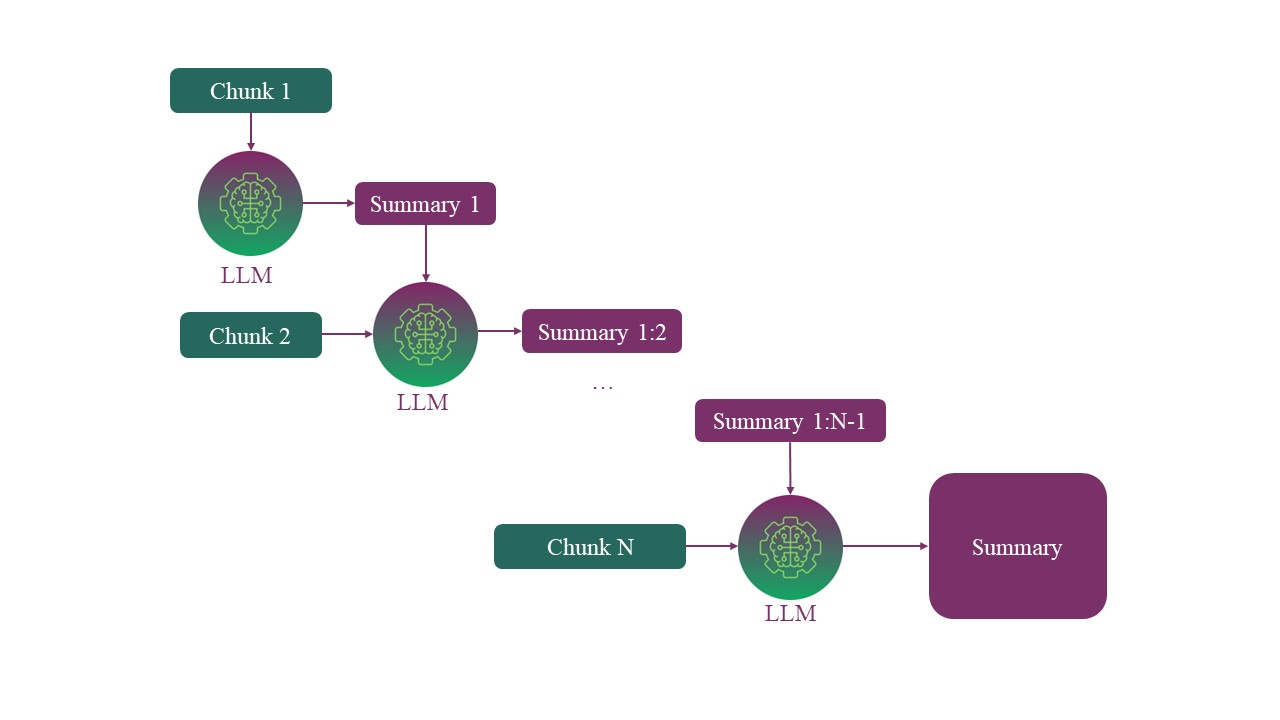
The Refine method is an alternative method to deal with large document summarization. It works by first running an initial prompt on a small chunk of data, generating some output. Then, for each subsequent document, the output from the previous document is passed in along with the new document, and the LLM is asked to refine the output based on the new document.

In [ ]:
question_prompt_template = """Write a summary of this chunk of text that includes the main points and any important details.
                            {text}"""

question_prompt = PromptTemplate(
    template=question_prompt_template, input_variables=["text"]
)

refine_prompt_template = """Write summary of the document by sections, then add key findings and conclusion.
                            The total length of the summary should be up to 3000 characters.
                            Input: ```{text}```    """

refine_prompt = PromptTemplate(
    template=refine_prompt_template, input_variables=["text"]
)

In [ ]:
refine_chain = load_summarize_chain(
    llm,
    chain_type="refine",
    question_prompt=question_prompt,
    refine_prompt=refine_prompt,
    return_intermediate_steps=True
)

In [ ]:
%%time
refine_outputs = refine_chain({"input_documents": test_pages}) # time: 20 min

In [ ]:
final_refine_data = []
for doc, out in zip(
    refine_outputs["input_documents"], refine_outputs["intermediate_steps"]
):
    output = {}
    output["file_name"] = p(doc.metadata["source"]).stem
    output["file_type"] = p(doc.metadata["source"]).suffix
    output["page_number"] = doc.metadata["page"]
    output["chunks"] = doc.page_content
    output["concise_summary"] = out
    final_refine_data.append(output)

In [ ]:
pdf_refine_summary = pd.DataFrame.from_dict(final_refine_data)
pdf_refine_summary = pdf_mp_summary.sort_values(
    by=["file_name", "page_number"]
)  # sorting the dataframe by filename and page_number
pdf_refine_summary.reset_index(inplace=True, drop=True)
# pdf_refine_summary.head()


In [ ]:
print(refine_outputs['output_text'] )

Summary by Sections:

Getting in Touch with the EU
This section outlines the various ways to get in touch with the European Union (EU). It mentions the hundreds of Europe Direct information centers across the EU, where you can find the address of the nearest center. It also provides information on contacting the Europe Direct service, which answers questions about the EU, either by freephone, standard number, or email.

Finding Information about the EU
This section discusses the different sources of information about the EU. The Europa website provides information in all official EU languages. EU publications, both free and priced, can be downloaded or ordered from the EU Publications Office website. The EUR-Lex website provides access to all EU law since 1952 in all official language versions. The EU Open Data Portal offers access to datasets from the EU, which can be downloaded and reused for free, for both commercial and non-commercial purposes.

Key Findings:
1. The EU provides var

In [ ]:
refine_scores = get_metrics(baseline_summary.content,
                generated_summary = refine_outputs['output_text'])

Rouge score:  [{'rouge-1': {'r': 0.13366336633663367, 'p': 0.18243243243243243, 'f': 0.15428570940473485}, 'rouge-2': {'r': 0.0219435736677116, 'p': 0.02834008097165992, 'f': 0.02473497741306644}, 'rouge-l': {'r': 0.1188118811881188, 'p': 0.16216216216216217, 'f': 0.13714285226187772}}]
BLEU Score: 0.00
BLEU Score: 0.00


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTscore: (tensor([0.8225]), tensor([0.8075]), tensor([0.8149]))
METEOR: 0.0


Pros and cons of Refine:
* (+) overcomes context window limitation,
* (-) multiple calls to LLM,
* (-) impossible to parallelize,
* (-) can have recency biased as the last chunks have more weight,
* (-) relevancy bias.

# K-means

The text is split into smaller chunks which are converted into embeddings. Then we apply a clustering method selecting a relevant number of clusters and finding the central embeddings to the centroids. Each of the central chunks are summarized and then the summaries are combined into a single summary.

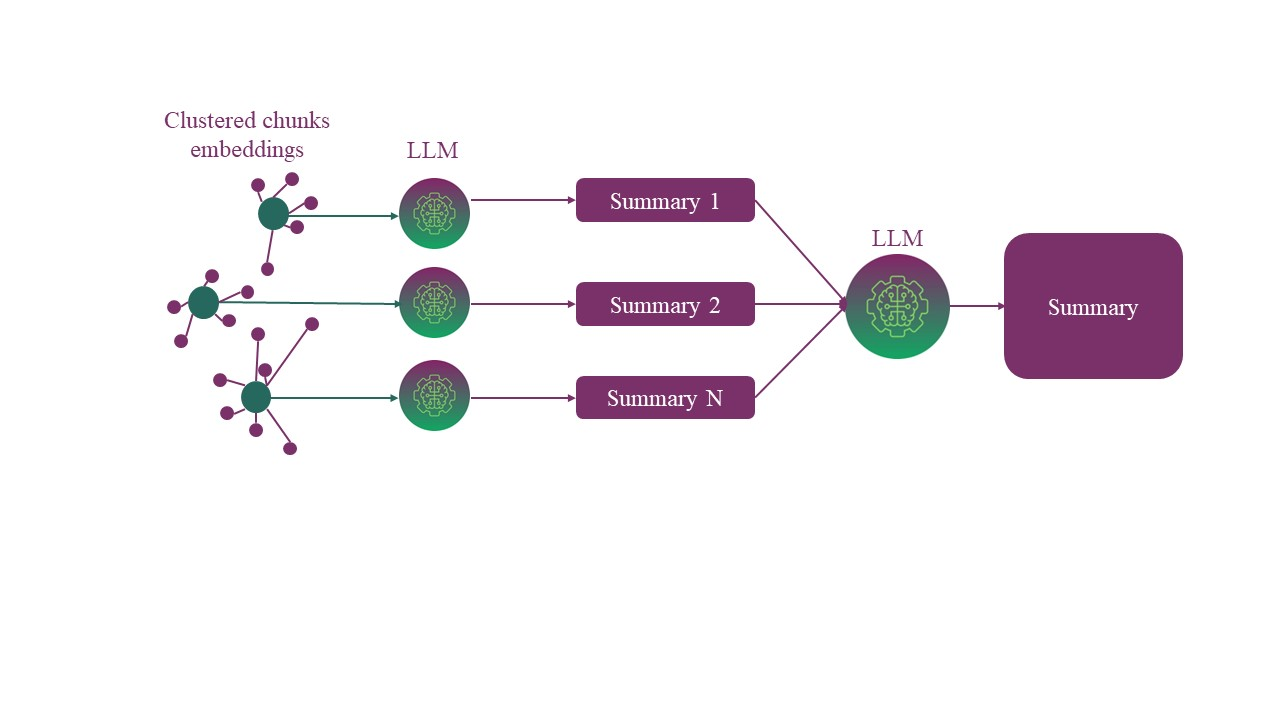
[Code source - LangChin Tutorial on Summarization](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/5%20Levels%20Of%20Summarization%20-%20Novice%20To%20Expert.ipynb)

In [ ]:
embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key)
vectors = embeddings.embed_documents([x.page_content for x in pages])

In [ ]:
# Perform K-means clustering
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

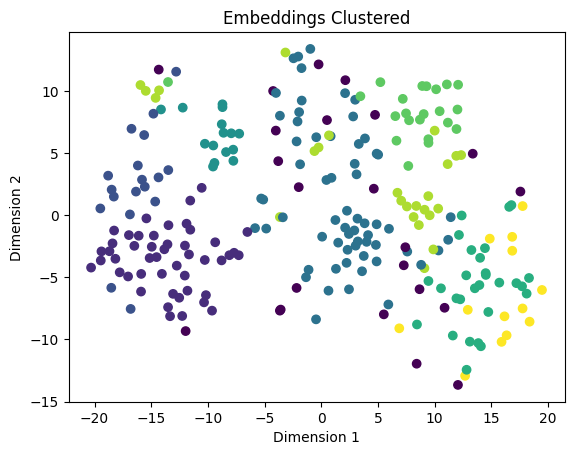

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(pd.DataFrame(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Embeddings Clustered')
plt.show()

In [ ]:
# Find the closest embeddings to the centroids
import numpy as np

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [ ]:
selected_indices = sorted(closest_indices)
selected_indices

[10, 12, 14, 30, 41, 50, 88, 123, 157, 217]

In [ ]:
llm3 = ChatOpenAI(temperature=0,
                 openai_api_key=openai.api_key,
                #  max_tokens=1000,
                 model='gpt-3.5-turbo'
                )

In [ ]:
map_prompt = """
Write a summary of this chunk of text that includes the main points and any important details.
                            {text}
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])
map_chain = load_summarize_chain(llm=llm3,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [ ]:
selected_docs = [pages[doc] for doc in selected_indices]
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Summary #0 (chunk #10) - Preview: This text discusses various countries' approaches to regulating artificial intelligence (AI) and managing the risks associated with it. Australia has a voluntary framework with AI ethics principles, while Canada has a Directive on Automated Decision- 

Summary #1 (chunk #12) - Preview: The text discusses various frameworks and initiatives at the international level related to the governance of artificial intelligence (AI), including those by organizations such as UNESCO, OECD, G20, and the Global Partnership on AI. It also mentions 

Summary #2 (chunk #14) - Preview: This text discusses a study that supports an impact assessment of regulatory requirements for artificial intelligence in Europe. The study considers five regulatory requirements listed in the AI White Paper and estimates the cost for each requirement 

Summary #3 (chunk #30) - Preview: The text discusses the impact of regulatory requirements for artificial intelligence (AI) in Europe, focu

In [ ]:
summaries = "\n".join(summary_list)
# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 1396 tokens


In [ ]:
combine_prompt = """
You will be given a series of summaries from a document. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what the document states and concludes.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [ ]:
reduce_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
#                              verbose=True # Set this to true if you want to see the inner workings
                                   )

In [ ]:
kmeans_output = reduce_chain.run([summaries])
print(kmeans_output)

The document provides a comprehensive discussion on the regulation and governance of artificial intelligence (AI) in various countries and on an international level. It highlights the different approaches used to manage AI risks, such as Australia's voluntary framework, Canada's Directive on Automated Decision-Making, Germany's risk classification system, Japan's Contract Guidelines, Singapore's model governance framework, the UK's guidance for public sector AI use, and the US's draft Guidance for AI Regulation. Additionally, it mentions international governance initiatives by UNESCO, OECD, G20, Global Partnership on AI, and standards bodies like ISO/IEC and IEEE, along with research institutions like AI Now.

The text also reveals the results of a public consultation on the European Commission White Paper on AI, with stakeholders expressing diverse views on the regulatory requirements proposed for high-risk AI. Concerns were raised about the clarity and effectiveness of the proposed v

In [ ]:
kmeans_scores = get_metrics(baseline_summary.content,
                generated_summary = kmeans_output)

Rouge score:  [{'rouge-1': {'r': 0.25742574257425743, 'p': 0.24761904761904763, 'f': 0.25242717946790466}, 'rouge-2': {'r': 0.10344827586206896, 'p': 0.09141274238227147, 'f': 0.09705881854848641}, 'rouge-l': {'r': 0.23267326732673269, 'p': 0.22380952380952382, 'f': 0.22815533480771058}}]
BLEU Score: 0.00
BLEU Score: 0.00


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTscore: (tensor([0.8629]), tensor([0.8529]), tensor([0.8579]))
METEOR: 0.0


Pros and cons of the clustering approach:
* (+) overcomes context window limitation,
* (+) a limited number of calls to LLM,
* (+) can be parallelized,
* (-) can miss the information as only centroid chunks are considered.

# French-RAPTOR
A more advanced option of clustering is described in Sarthi O., et al. RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval (2024). This is a novel approach of recursively embedding, clustering, and summarizing chunks of text, constructing a tree with differing levels of summarization from the bottom up. For the experiment, however, I used a simplified version of RAPTOR idea - [French-RAPTOR described at Medium by Clovis Varangot-Reille](https://medium.com/@clovis.vrgtR/frenchraptor-make-sure-your-rag-captures-the-essence-of-large-documents-mixtral-8x7b-96af7b347969).
The idea is to perform a few levels of clustering and summarization until getting the minimal number of clusters for the complete summary:

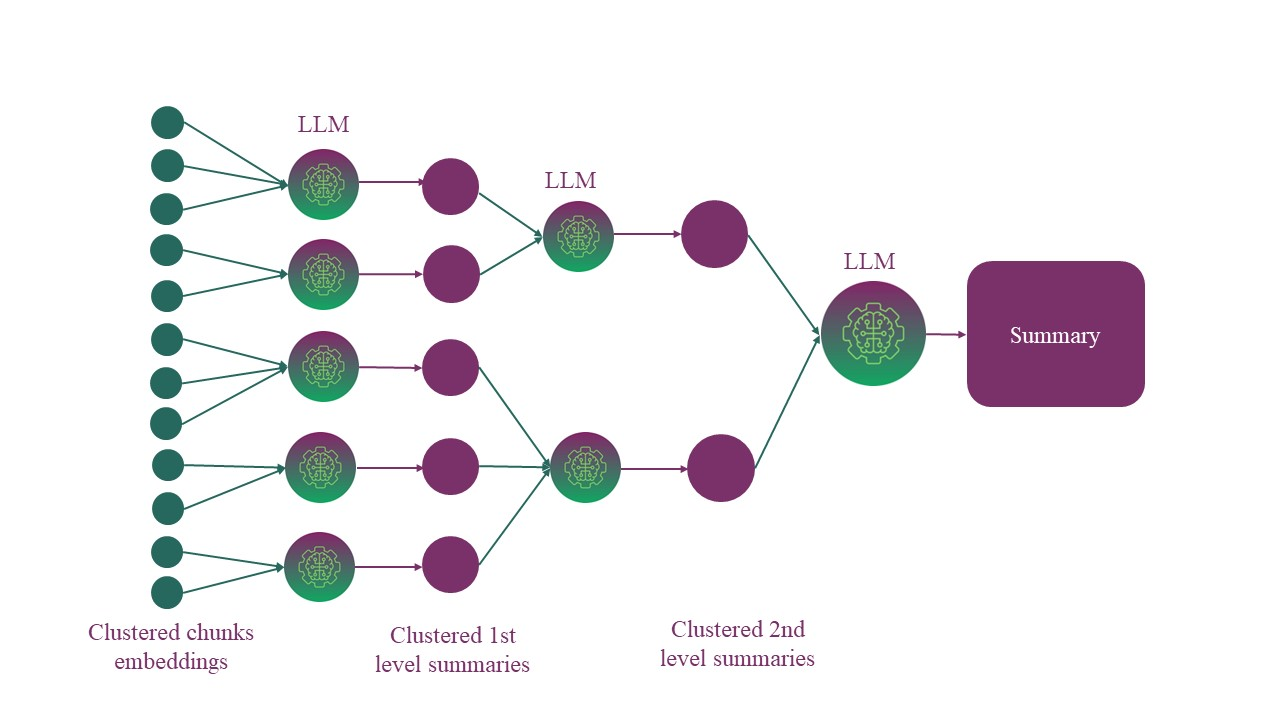

In [ ]:
class FrenchRAPTOR():
    def __init__(self,
                 embedding_function: Callable,  # A function of embedding of an instantiated model
                 model_llm: Callable) -> None: # The context of the document (e.g., AIact, a European AI regulation document)
        self.encode = embedding_function
        self.llm = model_llm
        self.chain_raptor()
        self.chain_raptor_summaryfinal() # Create the final summary with the context of the document
        self.plot_data = []  # This will store the silhouette scores and cluster numbers for each iteration

    def chain_raptor(self) -> None:
        # Construt the chain of the different iterations.
        prompt_raptor =  """
        Write a summary of this chunk of text that includes the main points and any important details.
        {text}
        """
        prompt_raptor_temp1 = PromptTemplate(input_variables=["text"], template=prompt_raptor)
        self.chainraptor_iter = LLMChain(prompt=prompt_raptor_temp1, llm=self.llm)

    def chain_raptor_summaryfinal(self) -> None :
        # Construct the chain of the final summary
        prompt_raptor_final =  """
        Write summary of the document by sections, then add key findings and conclusion.
                            The total length of the summary should be up to 3000 characters.
                            Input: ```{text}```
        """

        print(prompt_raptor_final)
        prompt_raptor_temp2 = PromptTemplate(input_variables=["text"], template=prompt_raptor_final)
        self.chainraptor_final = LLMChain(prompt=prompt_raptor_temp2, llm=self.llm)

    def fit(self,
            chunks: List[str],
            cluster_init_max: int = 25) -> Union[Dict[str, List[str]], List[str]]:
        """
        Fit the RAPTOR algorithm using KMeans hard clustering on the embeddings of the given chunks of text.

        This method iteratively clusters the text chunks, selects the best number of clusters based on silhouette scores,
        and generates summaries for each cluster. The process is repeated with the summaries, until we reach less than 4 clusters.
        Finally, a global summary is generated from the last set of chunks. It allows to have a hierarchical structure of summaries.

        Parameters:
        - cluster_init_max (int): The maximum initial number of clusters to consider for the first iteration.
        - chunks (List[str]): The initial chunks of text to be clustered and summarized.

        Returns:
        - Dict[str, List[str]]: A dictionary of hierarchical summaries
        - List[str]: The final corpus containing all generated summaries, including the global summary.

        """
        # We initialize the corpus
        corpus = chunks
        embeddings = self.encode(chunks) # We get the embedding of our documents
        cluster_chosen = cluster_init_max # We initialize the maximum of the range of the initial clustering
        d_resume = {}
        i = 0 # Initialize the level counter

        # Loop to build hierarchical summaries until the number of clusters is less than 5
        while cluster_chosen > 5:
            i += 1
            label = f'Summary {i}'
            d_resume[label] = []  # Initialize list for storing summaries at the current level
            d = {"n_cluster": [],
                "silhouette": []}
            range_n_clusters = range(3,cluster_chosen)

            # Loop over possible cluster numbers to find the best one based on silhouette score
            for n_clusters in range_n_clusters:
                clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init='auto') # Hard clustering
                clusterer.fit(embeddings) # Clustering on the embeddings
                d["n_cluster"].append(n_clusters)
                d["silhouette"].append(silhouette_score(embeddings, clusterer.labels_))

            self.plot_data.append({'n_cluster': d["n_cluster"], 'silhouette': d["silhouette"]})

            # Determine the optimal number of clusters with the highest silhouette score
            index_of_highest_silhouette = d["silhouette"].index(max(d["silhouette"]))
            cluster_chosen = d["n_cluster"][index_of_highest_silhouette]

            # print(f"\n{cluster_chosen} Clusters choisis pour les résumés de niveau {i} \n")
            # Perform clustering with the optimal number of clusters
            km_clusers = KMeans(n_clusters=cluster_chosen, random_state=10, n_init='auto').fit(embeddings)
            pred2 = km_clusers.predict(embeddings)

            # Generate summaries for each cluster
            list_resume = []
            for j in range(0, cluster_chosen):
                # print("\n Summary -", i," Cluster ", j, "\n")
                cluster_i = np.array(chunks)[pred2 == j]
                summary_raptor = self.chainraptor_iter.invoke({"text": cluster_i})
                answer = summary_raptor["text"].strip()
                # print(answer)
                list_resume.append(answer)
            # Process summaries to split and clean them (e.g., "1. The AIact....")
            list_resume = [re.split(r'\d+. ', document) for document in list_resume]
            list_resume = list(chain.from_iterable(list_resume)) # Flatten the list
            list_resume = [document for document in list_resume if len(document) > 2] # Remove empty items


            d_resume[label] = list_resume
            corpus = list(corpus) + list(list_resume) # Convert to list to ensure concatenation works as expected
            chunks = list_resume  # Use summaries as new chunks for the next iteration
            embeddings = self.encode(chunks) # Re-encode the new chunks

            if len(chunks) > cluster_init_max:
                cluster_chosen = cluster_init_max # To adapt range to current number of chunks after cleaning
            else:
                cluster_chosen = len(chunks) # To adapt range to current number of chunks after cleaning

        # Generate the global summary from the final set of summarie
        summary_raptor = self.chainraptor_final.invoke({"text": chunks})
        resume_global = summary_raptor["text"].strip()
        corpus = list(corpus) + [resume_global]
        d_resume['output_text'] = [resume_global]

        print("\n Final summary \n")
        print(resume_global)

        return d_resume, corpus

    def plot_silhouette(self):
        """Generates and displays subplots for the silhouette scores vs. the number of clusters for each iteration."""
        num_iterations = len(self.plot_data)
        if num_iterations == 0:
            print("Raptor n'a pas encore été lancé, veuillez commencez par utilisez la fonction fit() sur vos documents.")
            return

        # Calculate the number of rows required for subplots based on the number of iterations
        nrows = int(np.ceil(num_iterations / 2))
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
        axes = axes.flatten()  # Flatten the axes array for easy indexing

        for i, data in enumerate(self.plot_data):
            df_kmeans = pd.DataFrame({
                'n_cluster': data['n_cluster'],
                'silhouette': data['silhouette']
            })

            max_ind = np.argmax(df_kmeans["silhouette"])
            max_silhouette = df_kmeans["silhouette"][max_ind]
            max_cluster = df_kmeans["n_cluster"][max_ind]

            # Plotting on the i-th subplot
            axes[i].set_xticks(np.arange(df_kmeans['n_cluster'].min(), df_kmeans['n_cluster'].max() + 1, 1))
            sns.lineplot(data=df_kmeans, x="n_cluster", y="silhouette", color='#ff4255', ax=axes[i])
            sns.scatterplot(data=df_kmeans, x="n_cluster", y="silhouette", color='#ff4255', ax=axes[i], s=60)
            axes[i].plot(max_cluster, max_silhouette, "ko", ms = 10)
            axes[i].grid(axis='x')
            axes[i].set_title(f"Iteration {i+1}: Silhouette Score", fontsize=14)
            axes[i].set_xlabel("Nombre de clusters")
            axes[i].set_ylabel("Silhouette Score")

        # If the number of iterations is odd, hide the last subplot if it's unused
        if num_iterations % 2 != 0:
            axes[-1].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
model = SentenceTransformer("all-MiniLM-L12-v2")

Raptor = FrenchRAPTOR(model.encode, # The function to embed the documents
                           model_llm=llm)

In [ ]:
%%time
content_list = [i.dict()['page_content'] for i in test_pages]
raptor_output, corpus = Raptor.fit(chunks=content_list)

In [ ]:
print(raptor_output["output_text"])

Summary by Sections:

Section 1:
The provided text snippet appears to be referring to a monetary amount, specifically "€ per system." The main point conveyed is the mention of a specific euro amount, euros, associated with some kind of system or product. However, without additional context, it is difficult to provide a more detailed summary of the main points or important details.

Section 2:
The provided text does not contain any actual content to summarize. It only includes a statement indicating that a legal notice with key points should be provided, but the text of the legal notice is missing. Without the full text of the legal notice, I am unable to analyze the content and provide a meaningful summary of the main points and important details. I explicitly state that I cannot generate a summary without the complete text to review.

Section 3:
This text provides information about two types of identification numbers commonly used in contracts or agreements:

Contract number: This is 

In [ ]:
raptor_scores = get_metrics(baseline_summary.content,
                generated_summary = raptor_output['output_text'])

Rouge score:  [{'rouge-1': {'r': 0.18316831683168316, 'p': 0.20441988950276244, 'f': 0.1932114832656847}, 'rouge-2': {'r': 0.04075235109717868, 'p': 0.03869047619047619, 'f': 0.03969465149191836}, 'rouge-l': {'r': 0.17326732673267325, 'p': 0.19337016574585636, 'f': 0.18276761903591968}}]
BLEU Score: 0.00
BLEU Score: 0.00


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTscore: (tensor([0.8144]), tensor([0.8065]), tensor([0.8104]))
METEOR: 0.0


Pros and Cons of advanced clustering approaches:
* (+) overcomes context window limitation,
* (-) multiple calls to LLM,
* (-) can't be fully parallelized,
* (+) processes all the information,
* (-) relevancy bias.

# Conclusion

1. The key problems of long documents processing are:
    * context size limitations,
    * bias towards less important information and possibility of skipping the relevant pieces,
    * processing time and costs.

2. A choice of a specific summarization method should depend on a task, quality metrics and restrictions.

3. The standard quality metrics such as ROUGE or BERT scores can be quite ambiguous, and my suggestion is to come up with a better estimation practices either by having human-in-the-loop or by using another LLM for assessment.